In [1]:
import numpy as np
from matplotlib import pyplot as plt

# A Model for Campus Drinking 

Let craving at time $t$ be defined as $c(t)$ and let $c$ evolve according to
$$ \frac{dc}{dt} = f(c, m, t) $$
Where $m(t)$ is mood. We will use $m(t) = A\sin(2\pi a(t - \theta))$ so that mood oscilates between positive and negative with frequency $a$ oscilations per day.

Let probability of drinking at time $t$, $p(t)$ be described as follows
$$ \frac{dp}{dt} = g(p, c) $$

We add to this model a set of encounter times:
$$e = \{t_0, t_1, t_2, ...\}$$



When an encounter time is reached, the decision to drink is modeled as a random draw from $\text{Ber}(p(t_n))$.

Upon drinking, the individual experiences reduced craving, modeled as:
$$ c(t_n) \leftarrow c(t_n) - c_{drink} $$

In this notebook we will use
$$ f(c, m, t) = c_{\text{slope}}c - m(t)$$

where $c_{\text{slope}}$ is a parameter governing the rate of change change in craving and

$$ g(p, c) = \gamma[-p + \sigma(p + bc)] $$

where $\sigma(x) = \frac1{1+e^{-x}}$ and $b$ represents the magnitude of the impact of craving on probability of drinking. This ode comes from reservoir computing. The solution will remain in $[0, 1]$ for all time and respond to changes in craving.

Thus we have the following rules:
$$ \frac{dc}{dt} = c_{\text{slope}}c - m(t) $$

$$ \frac{dp}{dt}  = \gamma[-p + \sigma(p + bc)] $$

$$c(t_i) \leftarrow c(t_i) - c_{drink} \quad \text{if } t_i \in e $$

That define a change in drinking behavior.

Things to measure:
1. Synchronization (Kuramoto Order?)
2. Drinking Frequency

Drinking outside of encounter (should we call encounters opportunities?)
1. Craving/probability threshold where they will seek out alcohol

Encounters can come from social network
1. Will we need a driver or not
2. Is social drinking dissapative (is that the right word?)
3. Do you need ads to keep people drinking


### Model Equations

In [60]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def f_c(t, c, m, c_slope):
    return c_slope*c - m(t)

def f_p(t, p, c, b, gamma):
    return gamma * (-p + sigmoid(b*c))



### ODE Solver

The code below checks for a drinking encounter at each time step, makes necessary modifications to state variables, then steps forward in time with eulers method or RK4. Since the idea of discontinuous jumps in the ODE solution is used in neuroscience, the code below is a modification of a neuroscience solver for the [Izhikevich model](https://github.com/Jumaruba/SNN/blob/master/Neurons/IZHI.py).

In [61]:
def encounter(e, t, dt):
    """ Return `True` if current time is an encounter time
        Parameters
        e (ndarray): 1d array of encounter times
        t (float): current time
        dt (float): timestep size
        Returns:
        encounter (bool): True only if any encounter time falls in the 
            interval [t, t+dt)
    """
    enc = np.any((e < t + dt) * (e >= t ))
    return enc

def solve_euler(t, c, p, m, c_slope, b, gamma, dt): 
    """ Forward euler method for estimating next timestep
    """
    dc = f_c(t, c, m, c_slope, dt) * dt
    dp = f_p(t, p, c, b, gamma, dt) * dt
    return c + dc, p + dp

def solve_rk4(t, c, p, m, c_slope, b, gamma, dt):
    """ Fourth order Runga-Kutta method for estimating next timestep
    """
    dc1 = f_c(t, c, m, c_slope) * dt
    dc2 = f_c(t + 0.5*dt, c + dc1*0.5, m, c_slope) * dt
    dc3 = f_c(t + 0.5*dt, c + dc2*0.5, m, c_slope) * dt
    dc4 = f_c(t + dt, c + dc3, m, c_slope) * dt
    dc  = 1/6*(dc1 + dc2*2 + dc3*2 + dc4) 

    dp1 = f_p(t, p, c, b, gamma) * dt
    dp2 = f_p(t + 0.5*dt, p + dp1*0.5, c, b, gamma) * dt
    dp3 = f_p(t + 0.5*dt, p + dp2*0.5, c, b, gamma) * dt
    dp4 = f_p(t + dt, p + dp3, c, b, gamma) * dt
    dp  = 1/6*(dp1 + dp2*2 + dp3*2 + dp4) 

    return c + dc, p + dp 


def step(t, x, dt, params, method=0): 
    """ Check if the current time is an encounter time, modify state 
        accordingly, then step forward one timestep
    """
    if method != "rk4" and method != "euler":
        print("Invalid method\n\"euler\" - EULER\n\"rk4\" - RK4\n")
    # Unpack variables and parameters
    c, p, d = x[0], x[1], x[2]
    m, e, c_drink, c_slope, b, gamma = params
    
    # If the current time is an encounter time
    # Reset drink to zero
    d = 0
    if encounter(e, t, dt):
        # Draw from bernoulli variable for drinking
        if np.random.rand() < p:
            d = 1
            c -= c_drink
    # Step forward in time with desired method
    if method == "rk4": 
        c, p = solve_rk4(t, c, p, m, c_slope, b, gamma, dt)   
    elif method == "euler": 
        c, p = solve_euler(t, c, p, m, c_slope, b, gamma, dt)
    # Return updated states
    return t + dt, (c, p, d)


def simulate(x0, start, end, dt, params, method="euler"):
    """ Simulate the ODE
        Parameters:
        x0 (tuple): Tuple containing initial craving and initial drinking 
            probability `x0 = (c0, p0)`
        start (float): Start time
        end (float): End time
        dt (float): timestep size
        params (tuple): Tuple of parameters 
            `params = (m, e, c_drink, c_slope, b, gamma)` where:
            m (callable): mood variability function that accepts time 
               values
            e (ndarray): array of encounter times
            c_drink (float): amount that craving decreses in response 
                to a drink
            c_slope (float): Less than zero. Large magnitudes means that
                craving returns to pre-drinking levels faster
            b (float): magnitude of the impact of craving on probability 
                of drinking
            gamma (float): how quickly probability of drinking changes in 
                response to changes in craving
    """
    assert start < end
    # Number of timesteps
    N = int((end - start) / dt)
    t = start
    # Empty array for storing states
    states = np.zeros((N, 3))
    # Initial conditions
    d0 = 0
    xi = (*x0, d0)
    # Step forward in time and populate state array
    for i in range(N):
        t, xi = step(t, xi, dt, params, method=method)
        states[i, :] = xi
    t_range = np.arange(start, end, dt)
    return t_range, states

### Initialize Model Parameters

In [62]:
# Mood variability
A = 1.0
freq = 1.0
theta = 0
# Mood function
m = lambda t: A*np.sin(2*freq*np.pi*(t - theta))
# Encounter times
maxdays = 30
e = np.arange(1.0, maxdays)
# e = np.array([])
# Decrease in craving upon drinking
c_drink = 0.5
# Slope of craving
c_slope = -1
# Weight of craving on probability of drinking
b = 10.0
# Derivative magnitude
gamma = 1.0
# Package up parameters
params = (m, e, c_drink, c_slope, b, gamma)
# Initial conditions
c0 = 0.0
p0 = 0.0
start = 0.0
end = maxdays
dt = 0.01


### Run simulation

In [63]:
t, states = simulate((c0, p0), start, end, dt, params, method="rk4")

### Plot the simulation results

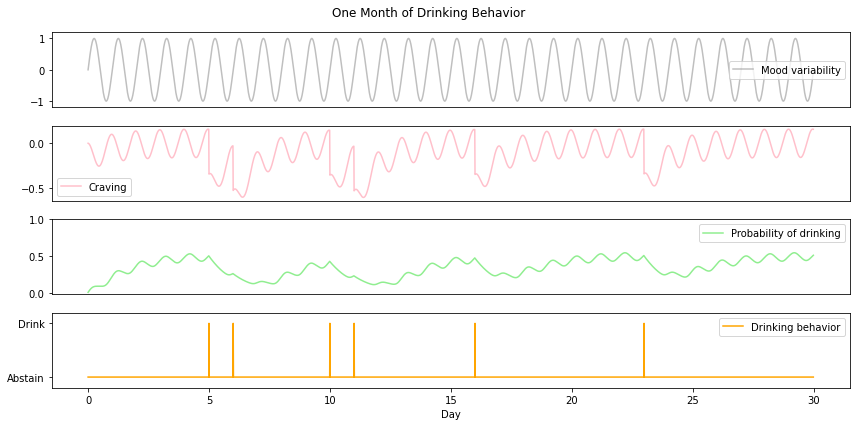

In [64]:
def plot_sim(t, states, colors):
    plt.rcParams["figure.figsize"] = [12, 6]
    c = states[:, 0]
    p = states[:, 1]
    d = states[:, 2]
    plt.subplot(411)
    plt.plot(t, m(t), c="grey", alpha=0.5, label="Mood variability")
    plt.xticks([],[])
    plt.ylim(-1.2, 1.2)
    plt.legend()
    plt.subplot(412)
    plt.plot(t, c, c="pink", label="Craving")
    plt.xticks([],[])
    plt.legend()
    plt.subplot(413)
    plt.plot(t, p, c="lightgreen", label="Probability of drinking")
    plt.yticks([0, .5, 1])
    plt.xticks([], [])
    plt.legend()
    plt.subplot(414)
    plt.plot(t, d, c="orange", label="Drinking behavior")
    plt.yticks([0, 1], ["Abstain", "Drink"])
    plt.ylim(-.2, 1.2)
    plt.xlabel("Day")
    plt.suptitle("One Month of Drinking Behavior")
    plt.tight_layout()
    plt.legend()
    plt.show()
    
plot_sim(t, states, colors)

### Studying parameters

In [65]:
# Impact of craving oscillation on probability of drinking. 
# Blind oscillation occurs if it is too large. b and gamma 
# need to be adjusted together to get the right kind of response
b = 10.0  
# High frequency mood changes don't allow probability of drinking to grow
# Long periods of negative mood lead to high drinking probability 
freq = 1.0
# Phase of negative moods is important. Negative mood reaching it's peak 
# a little before a drinking encounter leads to drinking probability rising
# and reaching a peak at the encounter (If gamma and b are large enough)
theta = 0.0
# How quickly craving returns to mood oscillation. Craving decreases after drinking
# Using a sine wave for mood creates an upward sloping sine wave that returns to normal 
# oscillating between -1 and 1 after a time. This occurs faster when c_slope is more negative
c_slope = -1.0 
# How quickly drinking probability responds to changes in craving
gamma = 10.0 

params = (m, e, c_drink, c_slope, b, gamma)

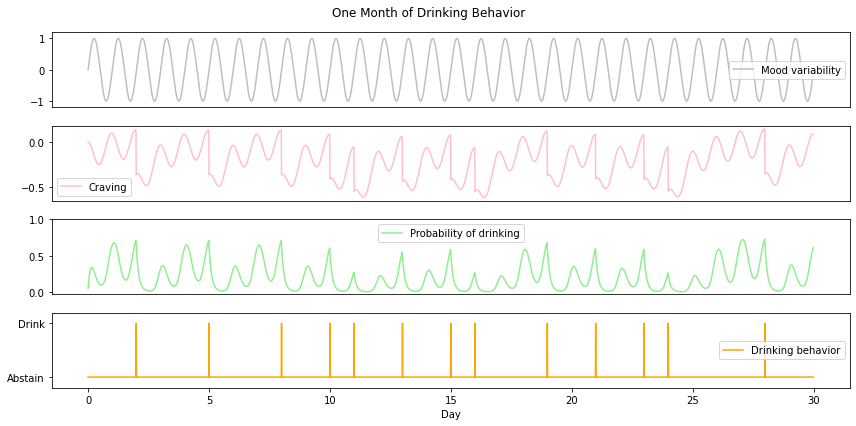

In [66]:
t, states = simulate((c0, p0), start, end, .01, params, method="rk4")
plot_sim(t, states, colors)